In [11]:
from typing import (Tuple, List, Dict, Union, Callable)
import pandas as pd
import numpy as np
import functools
from tqdm.notebook import tqdm
from scr.trader import Trader
from scr.company import Company
from scr.activation_funcs import identity, ReLU, sign, tanh
from scr.binary_operators import (operators_max, operators_min, operators_add,
                                  operators_diff, get_x, get_y, operators_multiple, x_is_greater_than_y)
import matplotlib.pyplot as plt


In [5]:
# import torch
# from torch.nn import (Tanh,ReLU)

# def dynamics(y_t:torch.tensor,sigma):

#     a,b = y_t
#     y_next = torch.zeros_like(y_t)
#     size = y_t.shape[1]
#     relu = ReLU()

#     y_next[0] =  1.0 * torch.tanh(a) + 0.8 * a * b + 1.0 * b - 1.0 * relu(torch.minimum(a,b)) + sigma * torch.randn(size)
#     y_next[1] = 0.6 * torch.sign(b) + 0.5 * a * b - 1.0 * torch.maximum(a,b) + sigma * torch.randn(size)

#     return y_next

# sigma_true = 0.1

# T_total = 2000
# y = torch.zeros((2, T_total))
# y_without_noise = torch.zeros((2, T_total))

# name_stock = dynamics(y,sigma_true)
# noise = dynamics(name_stock,0)

# # Nomura = name_stock[0]
# # PFN = name_stock[1]
# name_stock[:,0] = torch.tensor([0.5,0.5])
# noise[:,0] = torch.tensor([0.5,-0.5])
# name_stock_label = ["Nomura", "PFN"]

# plt.figure(figsize=(18,5))
# plt.xlim([T_total-100,T_total])
# plt.plot(name_stock[0].numpy(), color = "#cc0000", label = name_stock_label[0])
# plt.plot(name_stock[1].numpy(), color = "#083090", label = name_stock_label[1])
# plt.plot(noise[0].numpy(), color = "#cc0000", linestyle = "--", label = name_stock_label[0] + "(w/o noise)")
# plt.plot(noise[1].numpy(), color = "#083090", linestyle = "--", label = name_stock_label[1] + "(w/o noise)")
# plt.xlabel("time", fontsize = 18)
# plt.ylabel("y", fontsize = 18)
# plt.legend()

In [6]:
def dynamics(y_t: np.ndarray, sigma: float):

    a, b = y_t
    y_next = np.zeros_like(y_t)
    size = y_t.shape[1]

    y_next[0] = 1.0 * np.tanh(a) + 0.8 * a * b + 1.0 * b - 1.0 * ReLU(
        np.minimum(a, b)) + sigma * np.random.randn(size)
    y_next[1] = 0.6 * np.sign(b) + 0.5 * a * b - 1.0 * np.maximum(
        a, b) + sigma * np.random.randn(size)

    return y_next


T_total = 2000
sigma = 0.1
y = np.zeros((2, T_total))
data = dynamics(y, sigma)

In [7]:
# 如果有N个交易员的第I个股票用create_formulae生成一组formulae
def create_formulae(M: int,
                    A: List[Callable],
                    O: List[Callable],
                    stock_num: int,
                    max_lag: int = 9,
                    l: int = 1,
                    seed: int = None) -> List[Callable]:
    """构造$\Theta$
       $\Theta=\sum^{M}_{j}w_{j}A_{j}(O_{j}(r_{P_{j}}[t-D_{j}],r_{Q_{j}}[t-F_{j}]))$
       
    Args:
        M (int): 每位交易员表达式最大项数
        A (List[Callable]): 激活函数列表
        O (List[Callable]): 二元操作符函数列表
        stock_num (int): 股票个数
        max_lag (int, optional): 数据延迟最大取值. Defaults to 9.
        l (int, optional): 交易延迟量,即观察到数据后不可能立马进行交易,需要等待l时间. Defaults to 1.
        seed (int, optional): 随机数种子. Defaults to None.

    Returns:
        List: _description_
    """
    def _formula_func(data: np.ndarray, active_func: callable,
                      binary_oper: Callable, P: int, Q: int, F: int,
                      D: int) -> float:
        """_summary_

        Args:
            data (np.ndarray): 传入数据0轴为股票 1为时间

        """

        t = data.shape[1]  # 获取时间长度
        if t < (max_lag + l):
            raise ValueError('数据时间序列长度(t=%s)不能小于max_lag + l(max_lag+l=%s)!' %
                             (t, max_lag + l))

        # print('t=%s'%t)
        # print('D=%s,F=%s'%(D,F))
        # print('P=%s,Q=%s'%(P,Q))
        # print('active_func:%s,binary_oper:%s'%(active_func.__name__,binary_oper.__name__))
        # print(data)
        # print(data[P][t - D], data[Q][t - F])

        indices: np.ndarray = np.arange(max_lag + l, t)

        x: np.ndarray = np.take(data[P], indices - D)

        y: np.ndarray = np.take(data[Q], indices - F)

        # return active_func(binary_oper(data[P][t - D], data[Q][t - F]))
        return active_func(binary_oper(x, y))

    if seed:

        np.random.seed(seed)

    m = np.random.choice(M)  # 根据M最大项数选择个数

    # 构建延迟数
    a = np.arange(1, max_lag + l + 1)  # 最少为1天
    D: np.ndarray = np.random.choice(a, m)
    F: np.ndarray = np.random.choice(a, m)

    # 随机选择股票
    P: np.ndarray = np.random.choice(stock_num, m)
    Q: np.ndarray = np.random.choice(stock_num, m)

    # 列表中存放构成公式的"算子"
    formulae: np.ndarray = np.array(
        [np.random.choice(A, m),
         np.random.choice(O, m), P, Q, D, F],
        dtype='object').T

    # 列表中的func后续近仅需要传入data及对应的T即可得到返回值
    formulae_ls_func: List[Callable] = [
        functools.partial(_formula_func,
                          active_func=row[0],
                          binary_oper=row[1],
                          P=row[2],
                          Q=row[3],
                          F=row[4],
                          D=row[5]) for row in formulae
    ]

    return formulae_ls_func

In [87]:
# 假设只有一个交易员
# 第一个交易员的第0个股票的情况

activation_funcs = [identity, ReLU, sign, tanh]
binary_operators = [
    operators_max, operators_min, operators_add,
                                  operators_diff, get_x, get_y, operators_multiple, x_is_greater_than_y
]

# 一位trader的Theta
formulate = create_formulae(10,activation_funcs,binary_operators,stock_num=2,max_lag=2,l=1,seed=42)
# 生成初始权重数据
w:np.ndarray = np.random.randn(len(formulate)) 

In [88]:

# t最少为max_lag+l+1
p:List = []


for num,formula in enumerate(formulate):
    p.append(formula(data[:,:20]))
    
p:np.ndarray = np.vstack(p)

In [89]:
def calc_hist_cum(data:np.ndarray,w:np.ndarray)->float:
    """计算历史累计收益

    Args:
        data (np.ndarray): theta计算结果
        w (np.ndarray): 权重

    Returns:
        float: 累计收益
    """
    return (data * w).sum()

def aggregation_func(prediction_traders:np.ndarray,func:Callable):
    pass
    
def ols_func(exog:np.ndarray,endog:np.ndarray)->np.ndarray:
    
    if len(exog.shape) > 1:
        raise ValueError('exog仅能为向量.')
    
    A = np.vstack([np.ones(len(exog)),exog]).T
    b, _ = np.linalg.lstsq(A,endog, rcond=None)[0]
    return b

In [117]:
p.T @ w

array([-0.17314906,  0.01484481, -0.04687716, -0.12872449, -0.28498504,
       -0.05738728, -0.10800392, -0.11162071, -0.00650601,  0.20472095,
       -0.21326281, -0.01067333,  0.12166111,  0.0436511 ,  0.01717523,
       -0.14716824, -0.0195974 ])

In [118]:
np.linalg.matrix_rank(p.T.dot(p))

5

In [146]:
epsilon = 0.0001
a = A.T
np.linalg.inv(a.T.dot(a)+epsilon).dot(a.T).dot(data[0,:17])

ValueError: shapes (17,7) and (17,) not aligned: 7 (dim 1) != 17 (dim 0)

In [150]:
np.linalg.inv(a.T.dot(a)+epsilon).dot(a.T).dot(data[0,:17])

ValueError: shapes (17,7) and (17,) not aligned: 7 (dim 1) != 17 (dim 0)

In [147]:
data[0,:17]

array([ 0.06554018, -0.08846648,  0.13208644,  0.11443659,  0.23194131,
       -0.0324148 ,  0.07467131, -0.14399052,  0.03352619, -0.07730177,
        0.1455955 ,  0.01785697, -0.00161525, -0.01746369, -0.0615875 ,
       -0.04469934, -0.03764893])

In [140]:
import statsmodels.api as sm 

In [143]:
sm.OLS(data[0,:17],A).fit().summary()

d:\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     11.33
Date:                Mon, 20 Jun 2022   Prob (F-statistic):           0.000483
Time:                        17:12:46   Log-Likelihood:                 31.288
No. Observations:                  17   AIC:                            -50.58
Df Residuals:                      11   BIC:                            -45.58
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0438      0.029     -1.529      0.154      -0.107       0.019
x1            -0.2816      0.433     -0.650      0.529      -1.235       0.672
x2             0.0814      0.356      0.229      0.823      -0.703       0.865
x3         -2.352e-16    9.5e-17     -2.477      0.031   -4.44e-16   -2.62e-17
x4             1.1188      0.180      6.216      0.000       0.723       1.515
x5            -0.8095      0.567     -1.427      0.181      -2.058       0.439
x6             0.4021      0.189      2.130      0.057      -0.013       0.818
==============================================================================
Omnibus:                        6.536   Durbin-Watson:                   1.619
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                3.642
Skew:                          -0.961   Prob(JB):                        0.162
Kurtosis:                       4.204   Cond. No.                     2.72e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.31e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [139]:
np.linalg.lstsq(A,data[0,:17],rcond=-1)

(array([-4.38247063e-02, -2.81594789e-01,  8.14146369e-02, -2.22044605e-16,
         1.11879821e+00, -8.09482362e-01,  4.02128730e-01]),
 array([], dtype=float64),
 6,
 array([4.14166877e+00, 5.67269350e-01, 3.57327003e-01, 2.37673165e-01,
        1.63702956e-01, 6.41113015e-02, 1.52026312e-17]))

# 设置数据

In [73]:
def create_dataset(T, sigma_t):
    def simulation(y_t, sigma):
        y_t1 = np.zeros(2)
        y_t1[0] = 1.0 * tanh(
            y_t[0]) + 0.8 * y_t[0] * y_t[1] + 1.0 * y_t[1] - 1.0 * ReLU(
                min(y_t[0], y_t[1])) + sigma * np.random.randn()
        y_t1[1] = +0.6 * sign(y_t[1]) + 0.5 * y_t[0] * y_t[1] - 1.0 * max(
            y_t[0], y_t[1]) + sigma * np.random.randn()
        return y_t1

    y = np.zeros((2, T))
    y_without_noise = np.zeros((2, T))
    y[:, 0] = np.array([0.1, 0.1])
    y_without_noise[:, 0] = np.array([0.1, 0.1])

    for t in range(1, T):
        y[:, t] = simulation(y[:, t - 1], sigma_t)
        y_without_noise[:, t] = simulation(y[:, t - 1], 0.0)

    plt.plot(y[0], color="#cc0000", label="stock0")
    plt.plot(y[1], color="#083090", label="stock1")
    plt.plot(y_without_noise[0],
             color="#cc0000",
             linestyle="--",
             label="stock0" + "(w/o noise)")
    plt.plot(y_without_noise[1],
             color="#083090",
             linestyle="--",
             label="stock1" + "(w/o noise)")
    plt.xlabel("time", fontsize=18)
    plt.ylabel("y", fontsize=18)
    plt.xlim([T - 100, T])
    plt.legend()
    plt.show()
    plt.close()

    return y, y_without_noise

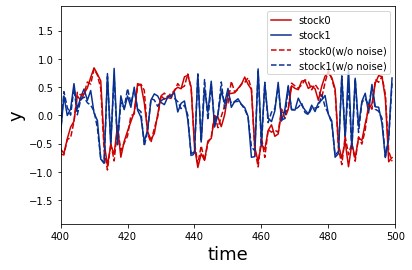

In [74]:
sigma = 0.1
T_total = 500
y, y_without_noise = create_dataset(T_total, sigma)

In [75]:
df_y = pd.DataFrame(y, index=["stock0", "stock1"]).T

df_y.head()

,stock0,stock1
0,0.100000,0.100000
1,0.006385,0.536425
2,0.685730,0.042710
3,0.564223,-0.059993
4,0.363967,-0.610318


# 训练

In [76]:
activation_funcs = [identity, ReLU, sign, tanh]
binary_operators = [
    operators_max, operators_min, operators_add, operators_diff, get_x, get_y,
    operators_multiple, x_is_greater_than_y
]

stock_names = ["stock0", "stock1"]
time_window = 200
delay_time_max = 2
num_factors_max = 4

model = Company(stock_names,
                num_factors_max,
                delay_time_max,
                activation_funcs,
                binary_operators,
                num_traders=40,
                Q=0.2,
                time_window=time_window,
                how_recruit="random")

In [77]:
T_train = 400
df_y_train = df_y.iloc[:T_train, :]
df_y_test = df_y.iloc[T_train:, :]

In [78]:
model.fit(df_y_train)

100%|██████████| 397/397 [02:26<00:00,  2.70it/s] 


In [32]:
model.aggregate()

array([0.01194506, 0.        ])

In [113]:
model.traders[0].X_factors[0] @ model.traders[0].w[0]

array([-0.65257574, -1.0403775 , -1.11805503, -1.06680376, -0.92886951,
       -0.71981898, -0.43354117,  0.12877966,  0.23427974,  0.45572782,
        0.33005764,  0.19549245,  0.3625305 ,  0.18080652, -0.05725416,
        0.0190606 , -0.00974848,  0.08079309, -0.01521828, -0.31900824,
       -0.74308221, -1.17732185, -1.06212834, -0.44840236,  0.21822674,
        0.2153747 ,  0.38427558,  0.2283021 ,  0.13593424,  0.01666133,
       -0.1113244 , -0.15161978, -0.37947188, -0.65546536, -1.02474106,
       -0.88124834, -0.81172995, -0.99316088, -1.14028301, -1.05887443,
       -0.56509165,  0.50593774,  0.09784648,  0.89187488,  0.29935443,
        0.71273439,  0.16058468,  0.56421745,  0.16598907,  0.07185967,
       -0.21533256, -0.63203505, -0.68171907, -0.96533636, -1.14476559,
       -0.74388403,  0.42936535,  0.12237527,  0.75706153,  0.16056152,
        0.52169713,  0.14572928,  0.3304663 ,  0.183821  ,  0.23223986,
        0.08034096,  0.11211194, -0.16529682, -0.37592175, -0.80

In [110]:
model.traders[0].X_factors[0].shape

(200, 3)

In [171]:
# for i,trader_model in enumerate(model.traders):

#     print(i,len(trader_model.num_factors))

# 测试

In [33]:
errors_test_notuning = []
for i, row in tqdm(df_y_test.iterrows()):
    prediction_test = model.aggregate()
    errors_test_notuning.append(np.abs(row.values - prediction_test))

    # tuning==Falseの場合、データが追加されても重みの更新などパラメータは変わらない
    model.fit_new_data(row.to_dict(), tuning=False)

errors_test_tuning = []
for i, row in tqdm(df_y_test.iterrows()):
    prediction_test = model.aggregate()
    errors_test_tuning.append(np.abs(row.values - prediction_test))

    # tuning==Trueの場合、データが追加された際に重みの更新などパラメータが調整される
    model.fit_new_data(row.to_dict(), tuning=True)

0it [00:00, ?it/s]

C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

0it [00:00, ?it/s]

C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

In [34]:
days_ma = 5

# trader-company errors with no-tuning
errors_test_notuning = np.array(errors_test_notuning)
errors_test_notuning_ma = pd.DataFrame(errors_test_notuning).rolling(
    days_ma).mean()

# trader-company errors with tuning
errors_test_tuning = np.array(errors_test_tuning)
errors_test_tuning_ma = pd.DataFrame(errors_test_tuning).rolling(
    days_ma).mean()

# baseline method
errors_baseline = np.abs(y[:, T_train + 1:] - y[:, T_train:-1])
errors_baseline_ma = pd.DataFrame(errors_baseline.T).rolling(days_ma).mean()

# lower bound
errors_lower_bound = np.abs(y[:, T_train + 1:] -
                            y_without_noise[:, T_train + 1:])
errors_lower_bound_ma = pd.DataFrame(
    errors_lower_bound.T).rolling(days_ma).mean()


stock0


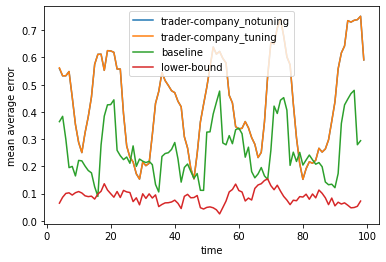

stock1


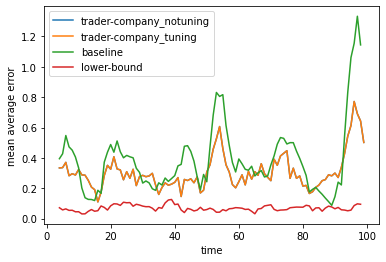

In [36]:
for i_stock, name in enumerate(stock_names):
    print(name)
    plt.plot(errors_test_notuning_ma[i_stock], label="trader-company_notuning")
    plt.plot(errors_test_tuning_ma[i_stock], label="trader-company_tuning")
    plt.plot(errors_baseline_ma[i_stock], label="baseline")
    plt.plot(errors_lower_bound_ma[i_stock], label="lower-bound")
    plt.xlabel("time")
    plt.ylabel("mean average error")
    plt.legend()
    plt.show()